In [2]:
import torch
import torch.nn.functional as F

from torch.func import jacrev, vmap
from scipy.stats import special_ortho_group

import matplotlib.pyplot as plt
from torch.special import chebyshev_polynomial_t as cheb

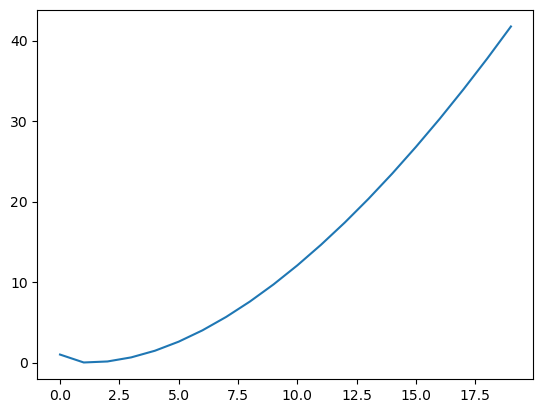

In [3]:
arccos = torch.arccos
pi = torch.pi
sqrt = torch.sqrt
def exact_relu_ntk(x_z, n=1, fac=2):
    u = lambda xx, xz, zz: (xz / sqrt(xx * zz)).clip(-1, 1)
    def relu_exp(xx, xz, zz):
        uu = u(xx, xz, zz)
        return sqrt(xx * zz) * (uu * (pi - arccos(uu)) + sqrt(1 - uu ** 2)) / 2 / pi * fac
    
    def relu_d_exp(xx, xz, zz):
        uu = u(xx, xz, zz)
        return (1/2 - arccos(uu)/2/pi) * fac
    
    def apply(f, tup):
        return f(tup[0], tup[0], tup[0]), f(*tup), f(tup[-1], tup[-1], tup[-1])
    
    tup_r = torch.tensor(1), x_z, torch.tensor(1)
    tup_dr = tup_r
    tup_theta = tup_r

    thetas = []
    
    for _ in range(n):
        tup_dr = apply(relu_d_exp, tup_r)
        tup_r = apply(relu_exp, tup_r)
        tup_theta = tuple(x*y + z for x, y, z in zip(tup_dr, tup_theta, tup_r))
        thetas += [tup_theta[1]]
        # thetas += [tup_r[1]]
    return thetas

# u = torch.linspace(-1, 1, 200)
# plt.plot(u, torch.stack(exact_relu_ntk(u, n=30)).T / torch.arange(1, 30 + 1))

def get_depth_weights(N, eps=1e-7):
    u = torch.tensor([-(1 - eps), 1 - eps]).float().requires_grad_(True)
    res = exact_relu_ntk(u, n=N)
    # (res[0] ** 2)
    a = []
    for i in range(N):
        res[i].sum().backward(retain_graph=i != N - 1)
        a.append((((u.grad * res[i].flip(dims=(0,))).sum() / (res[i] ** 2).diff())**2).squeeze().detach())
        u.grad = None
    a = torch.tensor(a)
    return a / a[0]
## empirically computed limit
plt.plot(get_depth_weights(20, eps=2e-7))

In [13]:
k0 = lambda xz: 1/pi * (pi - arccos(xz))
k1 = lambda xz: 1/pi * (xz * (pi - arccos(xz)) + sqrt(1 - xz ** 2))
C_cache = []
C1 = -2 ** 0.5 / pi
C_cache.append(C1)
C = C1
kj1 = torch.tensor(-1)
for j in range(1, 1000):
    C *= k0((kj1 := k1(kj1)))
    C_cache.append(C.item())
print(kj1)

tensor(1.0000)


Text(0, 0.5, 'M')

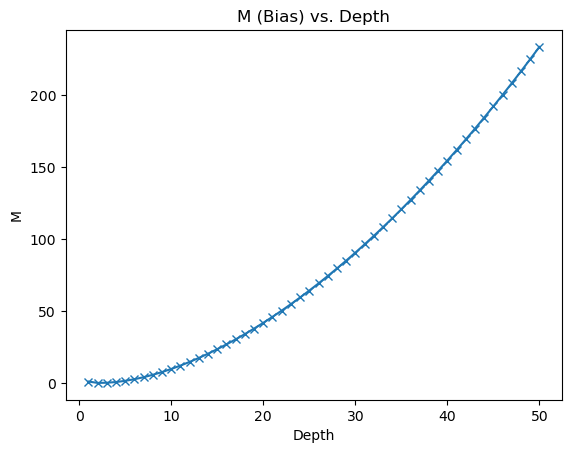

In [14]:
knp = torch.stack(exact_relu_ntk(torch.tensor([-1, 1]), n=50))
def compute_expression_direct(knp, k):
    kn, kp = knp
    C1 = C_cache[0]
    C = C_cache[k - 1]
    return ((kn * (2 ** 0.5 * k * (k + 1) / (C1 * pi)) + kp * (2 * C / C1)) / (kp ** 2 - kn ** 2)) ** 2
plt.title('M (Bias) vs. Depth')
plt.plot(range(1, len(knp) + 1), [compute_expression_direct(np, i + 1) for i, np in enumerate(knp)], 'x-')
plt.xlabel('Depth')
plt.ylabel('M')